# Demonstration of extracting specific letters from an image

First download and read an image

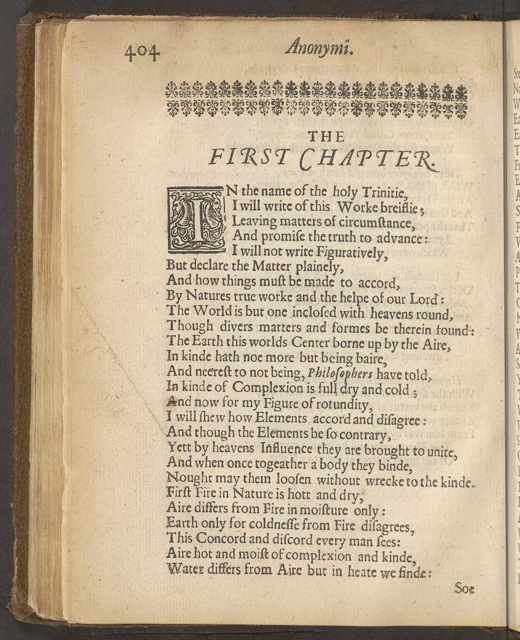

In [8]:
from IPython.display import display
from helpers import *

# Source: https://www.loc.gov/item/15004720/
from PIL import Image
im = Image.open("test.jpg")
thumb = im.copy()
thumb.thumbnail((640, 640))
display(thumb)

In [9]:
import pytesseract

tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = tesseract_cmd
ocr_data = pytesseract.image_to_data(im, output_type="data.frame")
ocr_data = ocr_data[ocr_data['text'].notnull()]
ocr_data = ocr_data[ocr_data['conf'] > 0]

print(ocr_data.head(10))

    level  page_num  block_num  par_num  line_num  word_num  left  top  width  \
9       5         1          2        1         1         2  1405  466     81   
10      5         1          2        1         1         3  1526  466     31   
13      5         1          2        1         1         6  2030  466     31   
17      5         1          2        1         2         1   855  583     27   
18      5         1          2        1         2         2  1486  629    174   
22      5         1          3        1         1         1  1006  712    394   
23      5         1          3        1         1         2  1445  714    677   
28      5         1          4        1         1         2  1097  881     32   
29      5         1          4        1         1         3  1167  887    238   
30      5         1          4        1         1         4  1420  885     67   

    height       conf      text  
9      121   8.609917        LY  
10     121  26.761238         T  
13    

Next, do OCR with tesseract

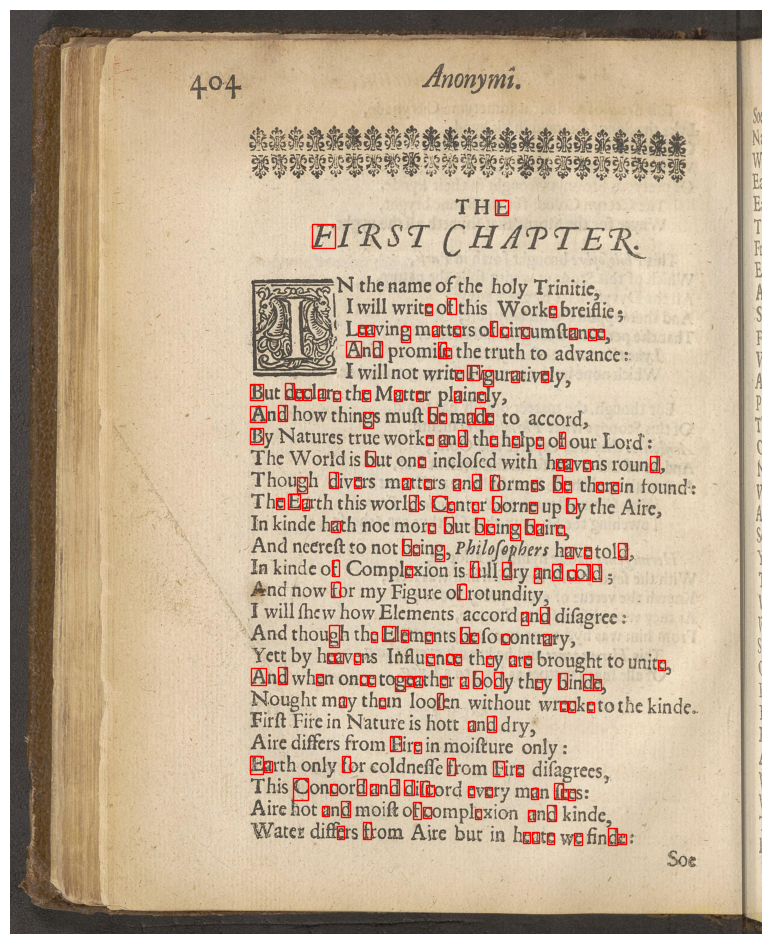

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches

def visualize_chars(im, chars, annotate=False):
    """
    Display bounding boxes and chars over source image
    """

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(im)
    ax.axis('off')
    for char, x0, y0, x1, y1, _conf in chars:
        box = patches.Rectangle(
            (x0, y0), x1 - x0, y1 - y0, edgecolor="red", facecolor="none"
        )
        ax.add_patch(box)
        if annotate:
            ax.annotate(
                char,
                (x0 + 2, y0 + 2),
                fontsize = 16,
                color = "green",
                verticalalignment = "top"
            )
    plt.show()

# Get bounding boxes of letters
letters = ("a", "b", "c", "d", "e", "f", "g", "A", "B", "C", "D", "E", "F", "G")
confidence_threshold = 85
words, chars = extract_letters(im, letters, tesseract_cmd, confidence_threshold)
visualize_chars(im, chars)


Next let's retrieve the image clips

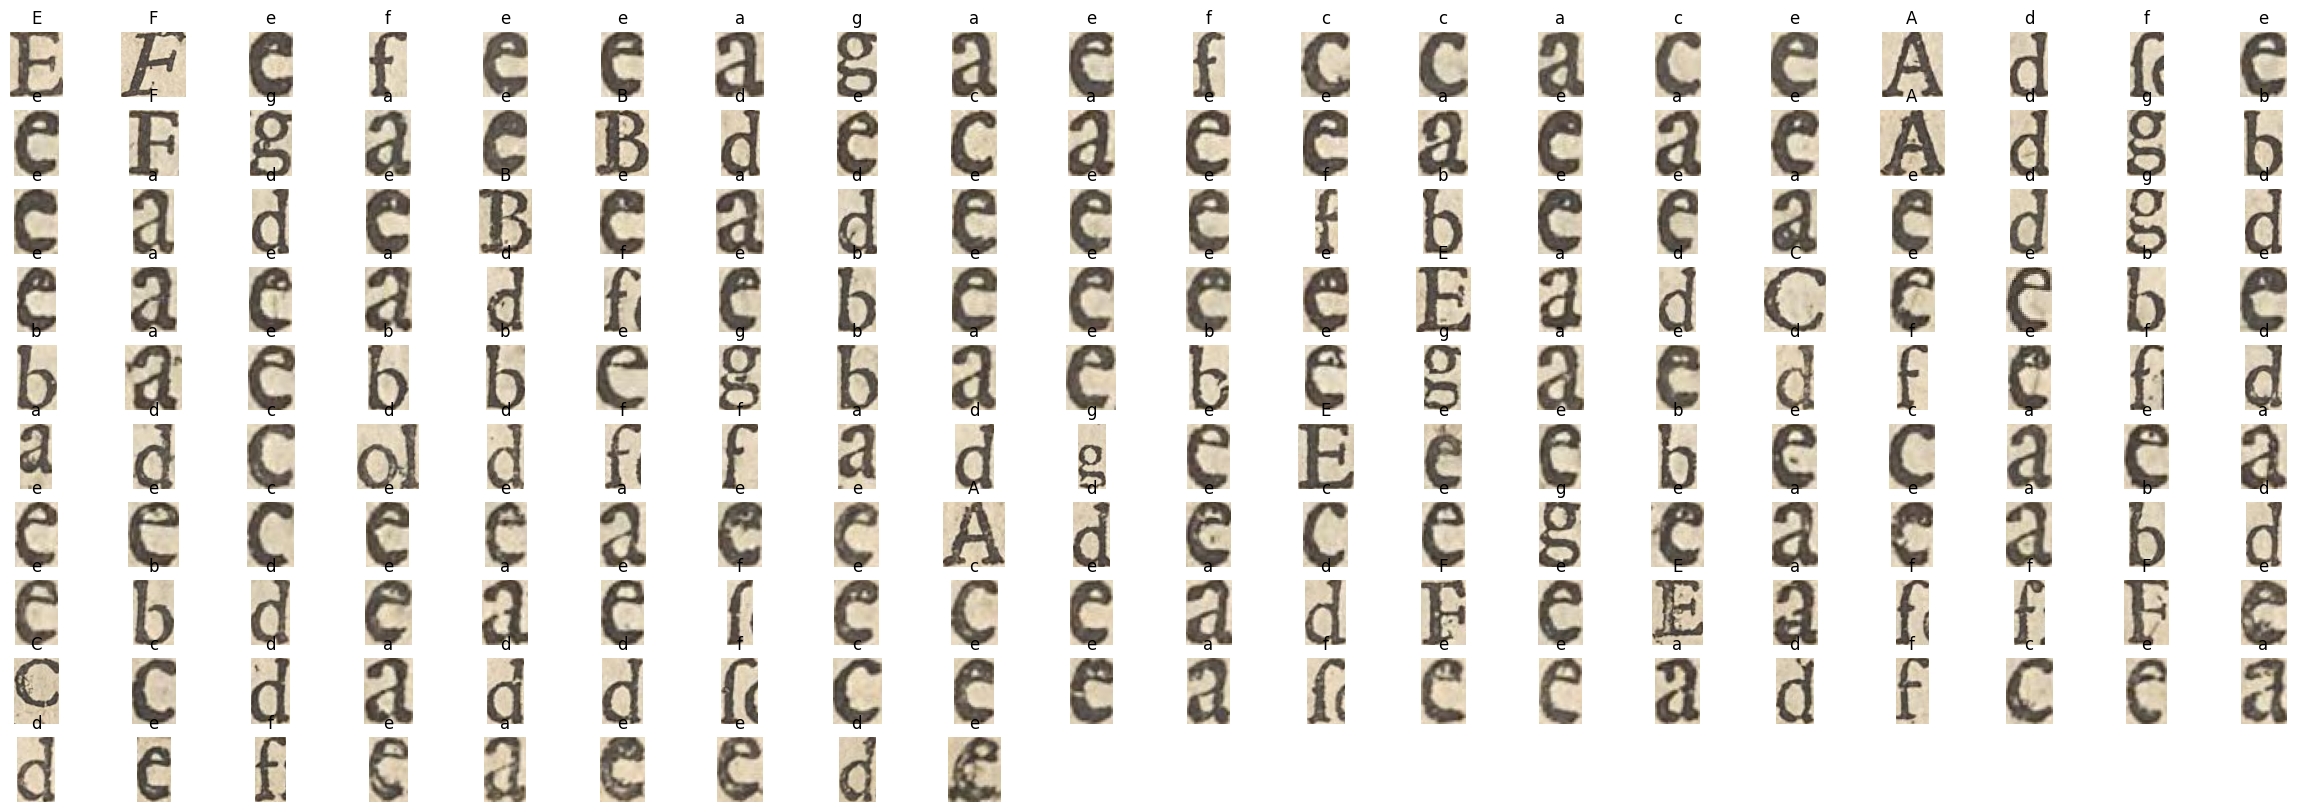

In [4]:
import math

clips = []
letters_per_row = 20
rows = int(math.ceil(1.0 * len(chars) / letters_per_row))
fig, ax = plt.subplots(rows, letters_per_row, figsize=(30, 10))
axes = list(ax.flat)
cells = letters_per_row * rows
for i in range(cells):
    if i < len(chars):
        char, x0, y0, x1, y1, _conf = chars[i]
        clip = im.crop((x0, y0, x1, y1))
        clips.append(clip)
        axes[i].imshow(clip)
        axes[i].set_title(char)
    axes[i].axis('off')
plt.show()

Attempt to only select the largest connected segment (and remove smaller segments)

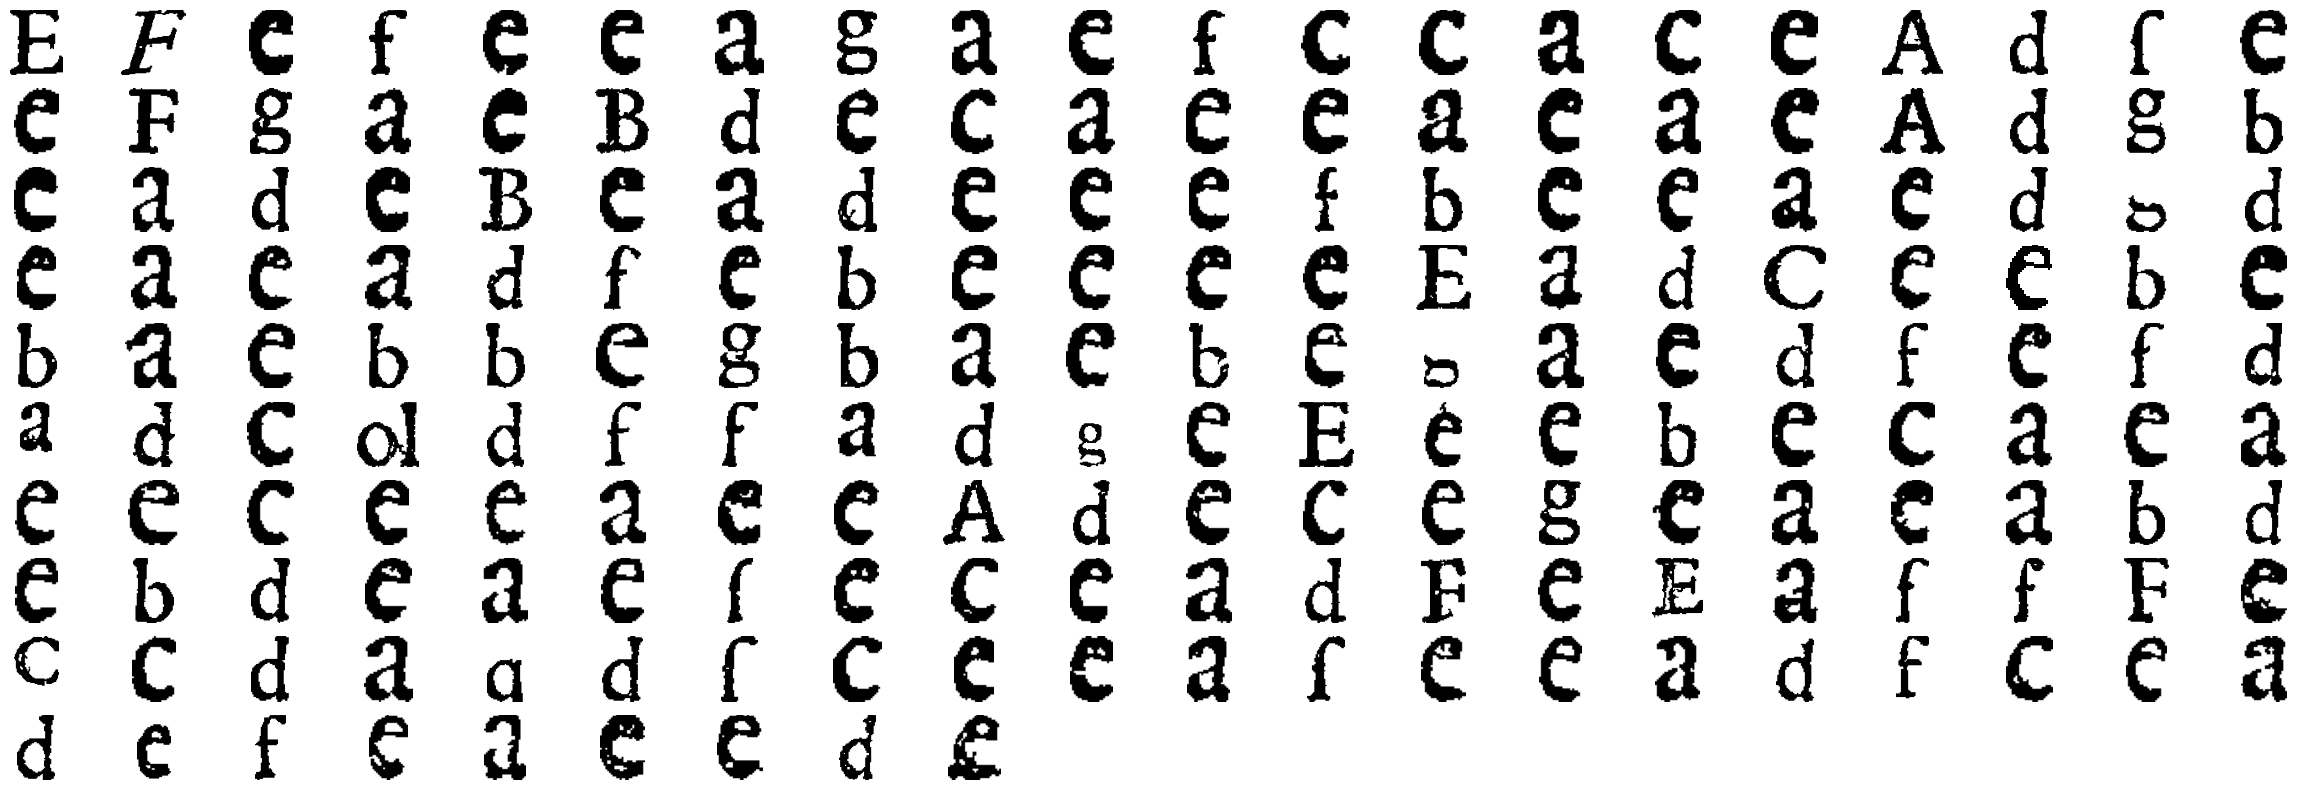

In [5]:
fig, ax = plt.subplots(rows, letters_per_row, figsize=(30, 10))
axes = list(ax.flat)
for i in range(cells):
    if i < len(clips):
        clip = clips[i]
        clip_largest_segment = get_largest_mask_segment(clip)
        clips[i] = clip_largest_segment
        axes[i].imshow(clip_largest_segment)
    axes[i].axis('off')
plt.show()

Attempt to trace the clips to create vectors that can be stored as SVG

In [6]:
from IPython.display import HTML
html = '<table style="background: white">'

for row in range(rows):
  html += '<tr>'
  for col in range(letters_per_row):
    i = row * letters_per_row + col
    if i >= len(clips):
      html += '<td></td>'
      continue
    clip = clips[i]
    svg = image_to_svg(clip, turdsize=5)
    html += f'<td>{svg}</td>'
  html += '</tr>'

html += '</table>'

display(HTML(html))